In [1]:
import os
import numpy as np
import mne
import imageio
import h5py
#import scipy.fftpack
import matplotlib
%matplotlib inline
import pywt
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
#from scipy import signal
from matplotlib.colors import ListedColormap
import time
import seaborn as sns
#import scipy.io as sio
#from scipy.integrate import simps
import pandas as pd
#from scipy import fft
import matplotlib.mlab as mlab
import sys
sys.path.append('T:\EL_experiment\Codes\CCEP_human\Python_Analysis/py_functions')
import analys_func
from scipy.stats import norm
import LL_funcs
from scipy.stats import norm
from tkinter import filedialog
from tkinter import *
import ntpath
root = Tk()
root.withdraw()
import math
import scipy
from scipy import signal
import pylab
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
import platform
from glob import glob
from scipy.io import savemat

import basic_func as bf
from scipy.integrate import simps
from numpy import trapz

import tqdm
from matplotlib.patches import Rectangle


import freq_funcs as ff
subj            = "EL018"
cwd             = os.getcwd()


path_patient = 'Y:\eLab\\Patients\\'+subj

path_analysis = 'Y:\eLab\RJB\Human_analysis\Patients\\'+subj

sep =';'    

color_elab      = ['#594157', "#F1BF98","#8FB996"]
lbls            = pd.read_excel(path_patient + "/infos/" + subj + "_labels.xlsx", header=0, sheet_name='BP')
labels_all      = lbls.label.values
labels_clinic   = lbls.Clinic.values
labels_region   = lbls.Region.values
labels_L        = lbls.Hemisphere.values
nodes           = pd.DataFrame({'ID': labels_all, 'Region': labels_region, 'H': labels_L})
coord_all       = np.array([lbls.x.values,lbls.y.values, lbls.z.values ]).T
#if subj == 'EL006':
 #     labels_all      = lbls.Clinic.values

bad_stims = np.where(labels_region=='OUT')[0]



In [138]:
Fs             = 500
dur            = np.zeros((1,2), dtype=np.int32)
t0 = 1
dur[0,0] =  -t0
dur[0,1] =  1

#dur[0,:]       = np.int32(np.sum(abs(dur)))
x_ax           = np.arange(dur[0,0],dur[0,1],(1/Fs))
color_elab      = np.zeros((4,3))
color_elab[0,:] = np.array([31, 78, 121])/255
color_elab[1,:] = np.array([189, 215, 238])/255
color_elab[2,:] = np.array([0.256, 0.574, 0.431])
cond_label = ['Pre', 'Post early', 'Post late', 'New']

## Read Data

In [192]:
prot = 'LTD50' #LTD1, LTD10
prot_num = 2

In [193]:
#still to do: select bad channels in epitome
bad_chans  = pd.read_csv(path_analysis + '\\LongTermInduction\\data\\badchan.csv')
bad_chans = np.unique(np.array(np.where(bad_chans.values[:,1:]==1))[0,:])

In [209]:
# load data
files = glob(path_analysis + '\\LongTermInduction\\data\\Stim_list_*')
file = files[1] # first file
EEG_resp = np.load(path_analysis + '\\LongTermInduction\\data\\All_resps_'+ntpath.basename(file)[10:-4]+'.npy')
stimlist = pd.read_csv(file)


##labels etc.
lbls = pd.read_excel(path_patient + "/infos/" + subj + "_labels.xlsx", header=0, sheet_name='BP')
labels_all, labels_region, labels_clinic, coord_all, StimChans, StimChanSM, StimChansC, StimChanIx, stimlist = bf.get_Stim_chans(
    stimlist,
    lbls)

In [210]:
# clean stimlist, dlete columns you dont need
for col in ['currentflow', 'TTL', 'TTL_PP', 'TTL_DS', 'TTL_PP_DS', 'sleep', 'sz', 'condition', 'Int_cond','ISI_s']:
    if col in stimlist: stimlist = stimlist.drop(columns=col)
        
stimlist.insert(6, 'Condition', 'Pre')
stimlist.loc[(stimlist.type=='LTP50_IO')&(stimlist.stim_block>4),'Condition'] ='Post_early'
stimlist.loc[(stimlist.type=='LTP50_IO')&(stimlist.stim_block>8),'Condition'] ='Post_late'

stimlist.loc[(stimlist.type=='LTP50_SP')&(stimlist.stim_block>1),'Condition'] ='Post_early'
stimlist.loc[(stimlist.type=='LTP50_SP')&(stimlist.stim_block>2),'Condition'] ='Post_late'

## Get LL of each stimulation trial and each channel

In [196]:
import IO_func as IOf
import basic_func as bf
import LL_funcs as LLf

In [197]:
def SM2IX(SM, StimChanNums, StimChanIx):
    # SM: stim channel in SM number
    # StimChanNums: all number of stim channels in SM
    # StimChanIx: all stim channels in all channels environment
    ChanIx = np.zeros_like(SM)
    for i in range(len(SM)):
        ChanIx[i] = StimChanIx[np.where(StimChanNums == SM[i])]
    return ChanIx

In [211]:
t_0=1
w_LL=0.25
data_LL = np.zeros((1, 12))  # RespChan, Int, LL, LLnorm, State
stim_spec = stimlist[(stimlist.IPI_ms == 0) ]  # &(stimlist.noise ==0)
stimNum = stim_spec.Num.values  # [:,0]
noise_val = stim_spec.noise.values  # [:,0]
if len(stimNum)>0:
    #resps = EEG_resp[:, stimNum, :]
    resps = EEG_resp[:, stimNum, :]
    ChanP1 = bf.SM2IX(stim_spec.ChanP.values, StimChanSM, np.array(StimChanIx))
    IPIs = np.expand_dims(np.array(stim_spec.IPI_ms.values), 1)
    #LL = LLf.get_LL_both(data=resps, Fs=Fs, IPI=IPIs, t_0=1, win=w)
    LL_trial = LLf.get_LL_all(resps[:, :, int(t_0 * Fs):int((t_0+0.5) * Fs)], Fs, w_LL)
    LL_peak = np.max(LL_trial, 2)
    t_peak = np.argmax(LL_trial, 2) + int((t_0 - w_LL / 2) * Fs)
    t_peak[t_peak < (t_0 * Fs)] = t_0 * Fs
    inds = np.repeat(np.expand_dims(t_peak, 2), int(w_LL * Fs), 2)
    inds = inds + np.arange(int(w_LL * Fs))
    pN = np.min(np.take_along_axis(resps, inds, axis=2), 2)
    pP = np.max(np.take_along_axis(resps, inds, axis=2), 2)
    p2p = abs(pP - pN)

In [212]:
for c in range(len(LL_peak)):
    val = np.zeros((LL_peak.shape[1], 12))
    val[:, 0] = c  # response channel
    val[:, 1] = ChanP1
    val[:, 4] = stim_spec.Int_prob.values  # Intensity
    val[:, 3] = noise_val
    val[:, 2] = LL_peak[c, :]  # PP
    val[:, 7] = stimNum
    val[:, 10] = stim_spec.stim_block.values
    val[:, 11] =  p2p[c, :]  # LL_peak_ratio[c, :]  # ratio
    # set stimulation channels to nan
    val[np.where(bf.check_inStimChan(c, ChanP1, labels_clinic) == 1), 3] = 1
    val[np.where(bf.check_inStimChan(c, ChanP1, labels_clinic) == 1), 2] = np.nan
    # if its the recovery channel, check if strange peak is appearing
    pks = np.max(abs(resps[c, :, np.int64((t_0 - 0.05) * Fs):np.int64((t_0 + 0.5) * Fs)]), 1)
    pks_loc = np.argmax(abs(resps[c, :, np.int64((t_0 - 0.05) * Fs):np.int64((t_0 + 0.5) * Fs)]), 1) + np.int64(
        (t_0 - 0.05) * Fs)
    ix = np.where(
        (pks > 500) & (pks_loc > np.int64((t_0 - 0.005) * Fs)) & (pks_loc < np.int64((t_0 + 0.008) * Fs)))
    # original stim number:
    sn = stim_spec.StimNum.values[ix]
    rec_chan = stimlist.loc[np.isin(stimlist.StimNum, sn - 1), 'ChanP'].values
    rec_chan = SM2IX(rec_chan, StimChanSM, np.array(StimChanIx))
    if np.isin(c, rec_chan):
        val[ix, 3] = 1

    data_LL = np.concatenate((data_LL, val), axis=0)

In [213]:
data_LL = data_LL[1:-1, :]  # remove first row (dummy row)
LL_all = pd.DataFrame(
    {"Chan": data_LL[:, 0], "Stim": data_LL[:, 1], "LL": data_LL[:, 2], "P2P": data_LL[:, 11], "Artefact": data_LL[:, 3],
     "Int": data_LL[:, 4], "Block": data_LL[:, 10],
     "Num": data_LL[:, 7],"Num_block": data_LL[:, 7]})

# distance
for s in np.unique(LL_all.Stim):
    s = np.int64(s)
    for c in np.unique(LL_all.Chan):
        c = np.int64(c)
        LL_all.loc[(LL_all.Stim == s) & (LL_all.Chan == c), 'd'] = np.round(
            scipy.spatial.distance.euclidean(coord_all[s], coord_all[c]), 2)

In [291]:
LL_all  = get_LL_all_LTI(EEG_resp, stimlist, lbls, bad_chans, Fs=500,t_0=1,w_LL=0.25)

In [290]:
def get_LL_all_LTI(EEG_resp, stimlist, lbls, bad_chans, Fs=500,t_0=1,w_LL=0.25):
    labels_all, labels_region, labels_clinic, coord_all, StimChans, StimChanSM,StimChansC, StimChanIx, stimlist = bf.get_Stim_chans(stimlist,
                                                                                                          lbls)
    data_LL = np.zeros((1, 12))  # RespChan, Int, LL, LLnorm, State
    stim_spec = stimlist[(stimlist.IPI_ms == 0) ]  # &(stimlist.noise ==0)
    stimNum = stim_spec.Num.values  # [:,0]
    noise_val = stim_spec.noise.values  # [:,0]
    if len(stimNum)>0:
        #resps = EEG_resp[:, stimNum, :]
        resps = EEG_resp[:, stimNum, :]
        ChanP1 = bf.SM2IX(stim_spec.ChanP.values, StimChanSM, np.array(StimChanIx))
        IPIs = np.expand_dims(np.array(stim_spec.IPI_ms.values), 1)
        #LL = LLf.get_LL_both(data=resps, Fs=Fs, IPI=IPIs, t_0=1, win=w)
        LL_trial = LLf.get_LL_all(resps[:, :, int(t_0 * Fs):int((t_0+0.5) * Fs)], Fs, w_LL)
        LL_peak = np.max(LL_trial, 2)
        t_peak = np.argmax(LL_trial, 2) + int((t_0 - w_LL / 2) * Fs)
        t_peak[t_peak < (t_0 * Fs)] = t_0 * Fs
        inds = np.repeat(np.expand_dims(t_peak, 2), int(w_LL * Fs), 2)
        inds = inds + np.arange(int(w_LL * Fs))
        pN = np.min(np.take_along_axis(resps, inds, axis=2), 2)
        pP = np.max(np.take_along_axis(resps, inds, axis=2), 2)
        p2p = abs(pP - pN)
        for c in range(len(LL_peak)):
            val = np.zeros((LL_peak.shape[1], 12))
            val[:, 0] = c  # response channel
            val[:, 1] = ChanP1
            val[:, 4] = stim_spec.Int_prob.values  # Intensity
            val[:, 3] = noise_val
            val[:, 2] = LL_peak[c, :]  # PP
            val[:, 7] = stimNum
            val[:, 10] = stim_spec.stim_block.values
            val[:, 11] =  p2p[c, :]  # LL_peak_ratio[c, :]  # ratio
            # set stimulation channels to nan
            val[np.where(bf.check_inStimChan(c, ChanP1, labels_clinic) == 1), 3] = 1
            val[np.where(bf.check_inStimChan(c, ChanP1, labels_clinic) == 1), 2] = np.nan
            # if its the recovery channel, check if strange peak is appearing
            pks = np.max(abs(resps[c, :, np.int64((t_0 - 0.05) * Fs):np.int64((t_0 + 0.5) * Fs)]), 1)
            pks_loc = np.argmax(abs(resps[c, :, np.int64((t_0 - 0.05) * Fs):np.int64((t_0 + 0.5) * Fs)]), 1) + np.int64(
                (t_0 - 0.05) * Fs)
            ix = np.where(
                (pks > 500) & (pks_loc > np.int64((t_0 - 0.005) * Fs)) & (pks_loc < np.int64((t_0 + 0.008) * Fs)))
            # original stim number:
            sn = stim_spec.StimNum.values[ix]
            rec_chan = stimlist.loc[np.isin(stimlist.StimNum, sn - 1), 'ChanP'].values
            rec_chan = SM2IX(rec_chan, StimChanSM, np.array(StimChanIx))
            if np.isin(c, rec_chan):
                val[ix, 3] = 1

            data_LL = np.concatenate((data_LL, val), axis=0)

        data_LL = data_LL[1:-1, :]  # remove first row (dummy row)
        LL_all = pd.DataFrame(
            {"Chan": data_LL[:, 0], "Stim": data_LL[:, 1], "LL": data_LL[:, 2], "P2P": data_LL[:, 11], "Artefact": data_LL[:, 3],
             "Int": data_LL[:, 4], "Block": data_LL[:, 10],
             "Num": data_LL[:, 7],"Num_block": data_LL[:, 7]})

        # distance
        for s in np.unique(LL_all.Stim):
            s = np.int64(s)
            for c in np.unique(LL_all.Chan):
                c = np.int64(c)
                LL_all.loc[(LL_all.Stim == s) & (LL_all.Chan == c), 'd'] = np.round(
                    scipy.spatial.distance.euclidean(coord_all[s], coord_all[c]), 2)
    return LL_all


In [296]:
LL_all.insert(4,'Condition', 'Pre')
LL_all.insert(4,'type', 'IO')
for stim_num in np.unique(LL_all.Num):
    LL_all.loc[LL_all.Num==stim_num, 'Condition'] = stimlist.loc[stimlist.Num == stim_num,'Condition'].values[0]
    LL_all.loc[LL_all.Num==stim_num, 'type'] = stimlist.loc[stimlist.Num == stim_num,'type'].values[0]

## Preliminary Plots

In [297]:
LL_all

,Chan,Stim,LL,P2P,type,Condition,Artefact,Int,Block,Num,Num_block,d
0,0.0,102.0,25.998563,885.456852,LTP50_IO,Pre,0.0,1.5,1.0,0.0,0.0,69.10
1,0.0,102.0,22.115129,700.003432,LTP50_IO,Pre,0.0,0.2,1.0,1.0,1.0,69.10
2,0.0,102.0,20.164321,757.773349,LTP50_IO,Pre,0.0,0.4,1.0,2.0,2.0,69.10
3,0.0,102.0,23.074959,801.065652,LTP50_IO,Pre,0.0,12.0,1.0,3.0,3.0,69.10
4,0.0,102.0,24.308554,906.431771,LTP50_IO,Pre,0.0,4.0,1.0,4.0,4.0,69.10
...,...,...,...,...,...,...,...,...,...,...,...,...
130266,117.0,102.0,1.356463,53.134401,LTP50_IO,Post_late,0.0,5.0,12.0,1098.0,1098.0,43.54
130267,117.0,102.0,1.687490,88.382333,LTP50_IO,Post_late,0.0,0.2,12.0,1099.0,1099.0,43.54
130268,117.0,102.0,1.334380,50.642634,LTP50_IO,Post_late,0.0,9.0,12.0,1100.0,1100.0,43.54
130269,117.0,102.0,1.513811,67.735628,LTP50_IO,Post_late,0.0,0.4,12.0,1101.0,1101.0,43.54


In [217]:
cond_labels = ['Pre','Post_early', 'Post_late'] # cond_labels = np.unique(LL_all.Condition)
cond_vals = np.arange(len(cond_labels))

In [225]:
chan_local = np.unique(LL_all.loc[LL_all.d<10,'Chan'])
chan_local

array([ 94.,  95.,  96., 100., 101., 102., 103., 108., 109., 110.])

In [ ]:
# bad_chans = 74, 75

In [238]:
np.median(dat.P2P)

284.8229965947972

In [316]:
rc = 1

In [337]:
rc

21

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


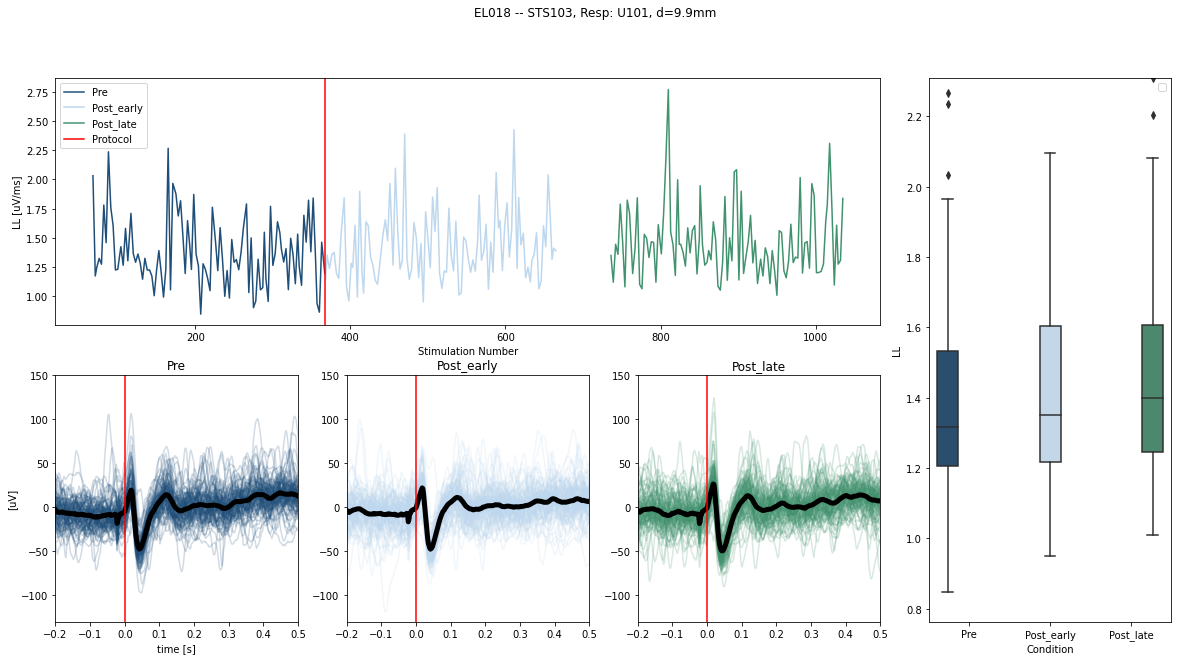

In [428]:
# select data for specific response channel (rc)
rc = rc+1
dat      = LL_all[(LL_all['LL']<10)&(LL_all['type']=='LTP50_SP')&(LL_all['Artefact']==0)&(LL_all['Chan']==rc)] #(LL_all['Stim']>32)& #&(LL_all['Sig_Con']>0)
sc = int(dat.Stim.values[0])

fig      = plt.figure(figsize=(20,10), facecolor='w', edgecolor='k')
plt.suptitle(subj+' -- '+labels_all[np.int64(sc)]+', Resp: '+labels_all[np.int64(rc)]+', d='+str(np.round(np.mean(dat.d),1))+'mm')    #
gs       = fig.add_gridspec(2,4)  # GridSpec(4,1, height_ratios=[1,2,1,2])
fig.add_subplot(gs[0, 0:3])
for c,i in zip(cond_labels, cond_vals):
    dat_plot = dat[(dat.Condition==c)]
    plt.plot(dat_plot.Num, dat_plot.LL, color=color_elab[i], label=c)
plt.xlabel('Stimulation Number')
plt.ylabel('LL [uV/ms]')
plt.axvline(np.max(dat.loc[(dat.Block==1),'Num'])+0.5, color=[1,0,0], label='Protocol')
plt.legend()  
ylim_mn = -100
ylim_mx = 100
for c,i in zip(cond_labels, cond_vals):
    fig.add_subplot(gs[1, i])
    dat_plot = dat[(dat.Condition==c)]
    
    for j in range(len(dat_plot.Num.values.astype('int'))):
        plt.plot(x_ax, EEG_resp[rc, dat_plot.Num.values.astype('int')[j],:],color=color_elab[i], alpha=0.2)
    plt.plot(x_ax, np.mean(EEG_resp[rc, dat_plot.Num.values.astype('int'),:],0),color=[0,0,0], linewidth=5)
    ylim_mx = np.max([ylim_mx, np.max(np.mean(EEG_resp[rc, dat_plot.Num.values.astype('int'),500:750],0))])
    ylim_mn = np.min([ylim_mn, np.min(np.mean(EEG_resp[rc, dat_plot.Num.values.astype('int'),500:750],0))])
    plt.xlim([-0.2, 0.5])
    plt.axvline(0, color=[1,0,0])
    plt.ylim([-200,200])
    if i==0:
        plt.xlabel('time [s]')
        plt.ylabel('[uV]')
    plt.title(c)
for i in range(len(cond_labels)):
    fig.add_subplot(gs[1, i])
    plt.ylim([1.3*ylim_mn, 1.5*ylim_mx])

fig.add_subplot(gs[:, 3])
sns.boxplot(x='Condition', y='LL', data = dat, hue = 'Condition', palette=color_elab)    
plt.xticks(np.arange(np.max(cond_vals)+1),cond_labels)
plt.ylim([0.9*np.min(dat.LL),np.percentile(dat.LL,99)])
plt.legend([])
plt.show()

## Input Output

### LL on mean CCEP(n=5 per block)

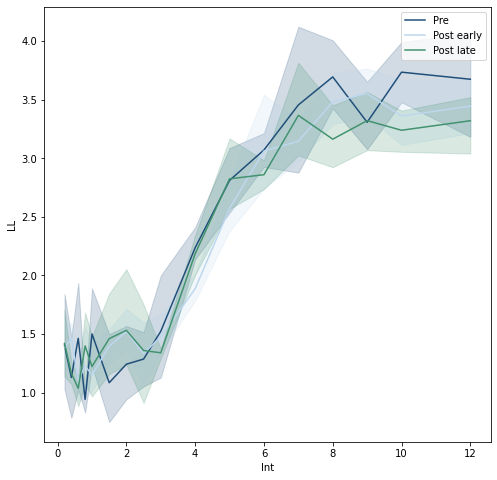

In [429]:
## mean LL of single trials LL  grouped based on condition

datIO      = LL_all[(LL_all['LL']<8)&(LL_all['type']=='LTP50_IO')&(LL_all['Artefact']==0)&(LL_all['Chan']==rc)] #(LL_all['Stim']>32)& #&(LL_all['Sig_Con']>0)
sc = int(datIO.Stim.values[0])
palette = sns.color_palette(color_elab[:3])
plt.figure(figsize=(8,8))
sns.lineplot(x='Int', y='LL', data=datIO, hue='Condition', palette = palette)
plt.legend(cond_label[:3])


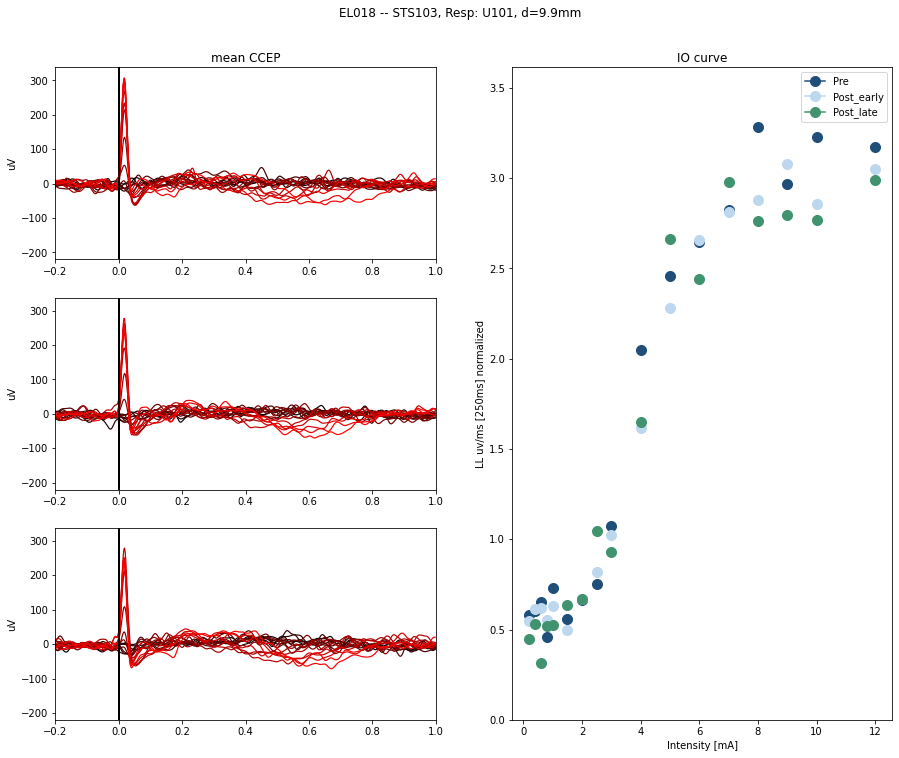

In [430]:
## LL of mean CCEP (slighlty different)
sc = int(datIO.Stim.values[0])
plot_raw_LL_IO_LTI(sc, rc, datIO,EEG_resp,labels_all)

In [270]:
def plot_raw_LL_IO_LTI(sc, rc, LL_all,EEG_resp,labels_all):
    dat      = LL_all[(LL_all['Stim']==sc)&(LL_all['Chan']==rc)]
    w        = 0.25
    fig, axs = plt.subplots(len(cond_vals),2, figsize=(15, 8), facecolor='w', edgecolor='k')
    axs     = axs.ravel()
    plt.close(fig) # todo: find better solution
    fig      = plt.figure(figsize=(15,len(cond_vals)*4), facecolor='w', edgecolor='k')
    #
    gs       = fig.add_gridspec(len(cond_vals),2)  # GridSpec(4,1, height_ratios=[1,2,1,2])
    for n in cond_vals:
        axs[n] = fig.add_subplot(gs[n, 0])

    axIO   = fig.add_subplot(gs[:, 1])
    plt.suptitle(subj+' -- '+labels_all[np.int64(sc)]+', Resp: '+labels_all[np.int64(rc)]+', d='+str(np.round(np.mean(dat.d),1))+'mm', y=0.95)
    limy_LL          = 3 # limits for LL plot
    limy_mx        = 200
    limy_mn        = -200
    Int_selc         = np.unique(dat.Int)
    colors_Int       = np.zeros((len(Int_selc), 3))
    colors_Int[:, 0] = np.linspace(0, 1, len(Int_selc))
    mx_LL =1
    for c,j in zip(cond_labels, cond_vals):
        Int_selc = np.unique(dat.loc[(dat.Stim==sc)&(dat.Chan==rc)&(dat.Condition==c), 'Int'])
        for i in range(len(Int_selc)):
            dati = dat[(dat.Int==Int_selc[i])&(dat.Stim==sc)&(dat.Chan==rc)&(dat.Condition==c)]
            if len(dati)>0:
                resp             = ff.lp_filter(np.nanmean(EEG_resp[rc,dati.Num.values.astype('int'),: ], 0),45,Fs)
                LL_resp = LLf.get_LL_all(np.expand_dims(resp,[0,1]), Fs, 0.25)[0][0]

                LL_resp             = ff.lp_filter(LL_resp,20,Fs)
                axs[j].plot( x_ax,resp, c = colors_Int[i], linewidth= 1.2)
                axs[j].set_xlim(-0.2, 0.5)
                # axs[1].plot( x_ax,LL_resp, c = colors_Int[i], linewidth= 1.2)
                mx = np.max(LL_resp[500:750])
                mx_t = np.argmax(LL_resp[500:750]) /Fs
                # axs[1].plot(mx_t,mx, marker='o', c = [0,0,0], markersize= 10)

                
                if i == len(Int_selc)-1:
                    axIO.plot(Int_selc[i], mx, marker='o', markersize=10, c = color_elab[j], label=c)
                else:
                    axIO.plot(Int_selc[i], mx, marker='o', markersize=10, c = color_elab[j])
                limy_mx = np.nanmax([limy_mx, np.max(resp[500:750])])
                limy_mn = np.nanmin([limy_mn, np.min(resp[500:750])])
                mx_LL = np.max([mx_LL, mx])
                axs[j ].axvline(0, c=[0,0,0])   
                axs[j].set_xlim(-0.2, 1)
                axs[j].set_ylabel('uV')


    axIO.set_title('IO curve')
    axIO.set_ylabel('LL uv/ms [250ms] normalized')
    axIO.set_xlabel('Intensity [mA]')
    axIO.set_ylim([0,1.1*mx_LL])
    axIO.legend()

    axs[0].set_title('mean CCEP')

    
    # axs[1].set_ylabel('uV/ms')
    for n in cond_vals:
        axs[n].set_ylim(1.1*limy_mn,1.1*limy_mx)